# references

http://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html

https://stackoverflow.com/questions/21104664/extract-all-bounding-boxes-using-opencv-python

http://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_label.html

    

In [39]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure, measure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray, gray2rgb
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from multiprocessing.pool import ThreadPool
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [129]:
dicesToRead = ['01', '02', '03','04','05','06','07','08', '09', '10', '11', '12','13','14','15','16','17']
# dicesToRead = ['08']
def drawDiceImage(i, img):
    plt.subplot(6,3,i)
    plt.imshow(img)

In [130]:
dices = [io.imread('./dices/dice{0}.jpg'.format(i)) for i in dicesToRead]

In [111]:
def getEdges(img, gamma = 0.7, sig=3, l=0, u=100): #gama 0.7 sig = 4.65
    img = rgb2gray(img)
    pp,pk = np.percentile(img,(l,u));
    img = exposure.rescale_intensity(img,in_range=(pp,pk))
    from skimage import feature
    img = img ** gamma
    img = ski.feature.canny(img, sigma=sig)
    return img

In [92]:
def getEdges(img, gamma = 0.7, sig=3, l=0, u=100): #gama 0.7 sig = 4.65 ##TEST ONLY
    img = rgb2gray(img)
    img = ski.feature.canny(img, sigma=sig)
    return img

In [7]:
def findCircles(image, edges):
    # Detect two radii
    hough_radii = np.arange(5, 15, 4)
    hough_res = hough_circle(edges, hough_radii)

    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=10)

    # Draw them
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = gray2rgb(image)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        image[circy, circx] = (220, 20, 20)
    return image

In [112]:
def drawDices(gamma=1.4, sig = 1.7, l=50, u=100):
    fig = plt.figure(facecolor="black", figsize=(60,60))
    i = 1
    for img in dices:
        edges = getEdges(img, gamma, sig, l, u)
        contours = measure.find_contours(edges, 0.5, fully_connected="high")
        fig, ax = plt.subplots()
#         ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
        values = []
        for n, contour in enumerate(contours):
#             region = regionprops(contour)
#             print(region)
#             if region.area > 50:
                
#             roi=im[y:y+h,x:x+w]
        
#             if h > 10 and w > 10:
#                 values.append([y, x, h, w])
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

#         ax.axis('image')
#         img = findCircles(img, edges)
#         drawDiceImage(i, edges)
        i +=1 
#         drawDiceImage(i, img)
        print(values)
    plt.tight_layout()
    plt.show()
    fig.savefig("dices.pdf",facecolor="black")
    plt.close()

interact(drawDices, gamma=(0.1,2,0.1), sig=(0.1,4,0.1), l=(0,100,1), u = (0,100,1))

interactive(children=(FloatSlider(value=1.4, description='gamma', max=2.0, min=0.1), FloatSlider(value=1.7, description='sig', max=4.0, min=0.1), IntSlider(value=50, description='l'), IntSlider(value=100, description='u'), Output()), _dom_classes=('widget-interact',))

<function __main__.drawDices>

interactive(children=(FloatSlider(value=0.4, description='gamma', max=2.0, min=0.1), FloatSlider(value=2.7, description='sig', max=4.0, min=0.1), IntSlider(value=91, description='l'), IntSlider(value=90, description='u'), Output()), _dom_classes=('widget-interact',))

<function __main__.drawDices>

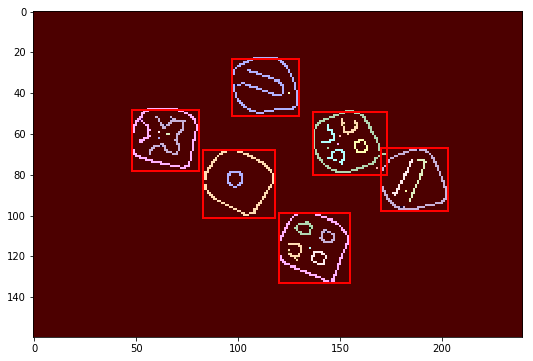

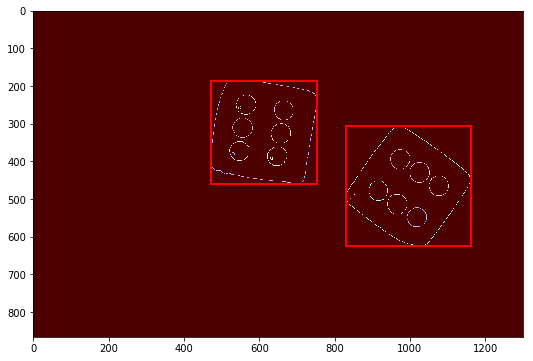

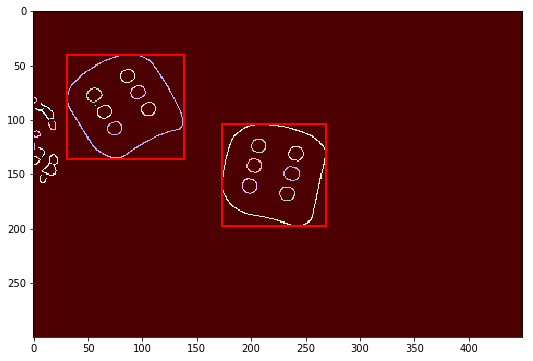

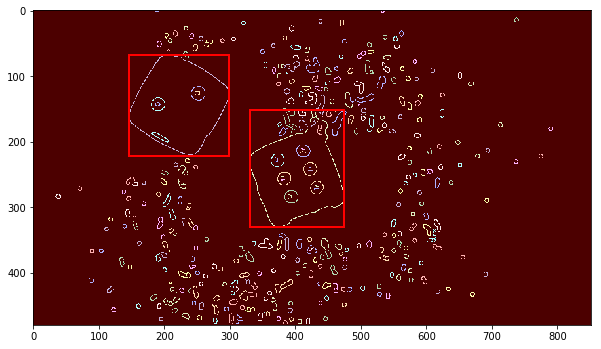

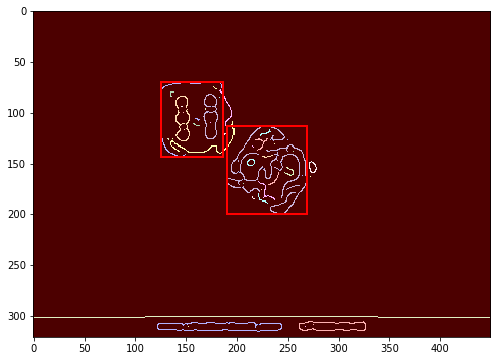

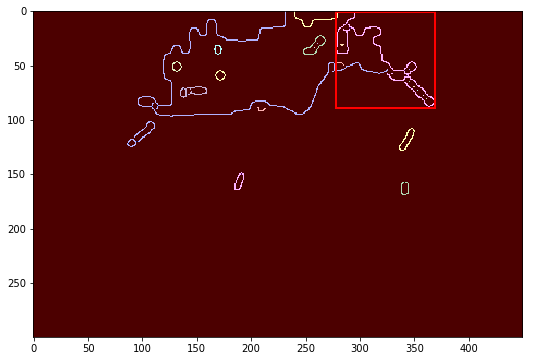

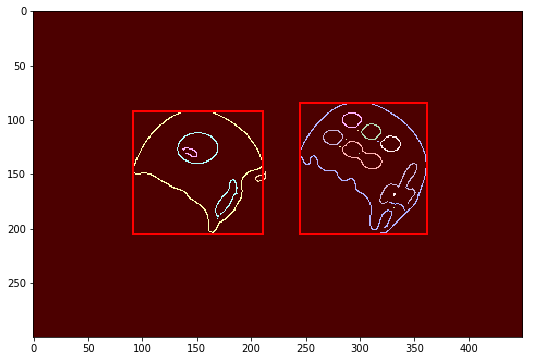

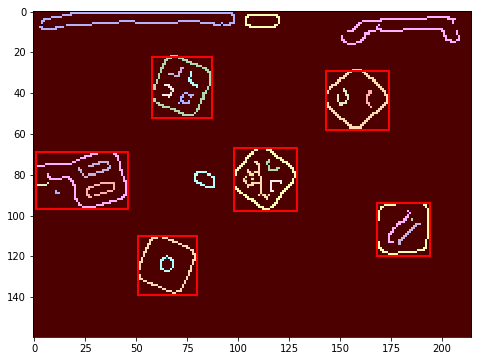

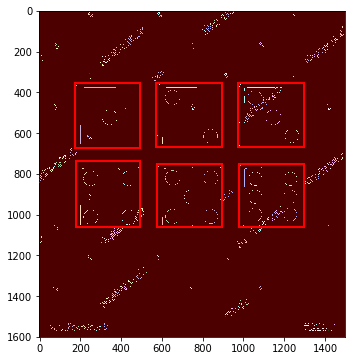

In [193]:
def drawDices(gamma=0.4, sig = 2.7, l=91, u=90): ##RECTANGLES
    fig = plt.figure(facecolor="black", figsize=(60,60))
    i = 1
    for image in dices:
        image = getEdges(image, gamma, sig, l, u)
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(2))

        # remove artifacts connected to image border
        cleared = clear_border(bw)

        # label image regions
        label_image = label(cleared)
        image_label_overlay = label2rgb(label_image, image=image)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(image_label_overlay)
        values = []
        for region in regionprops(label_image):
            # take regions with large enough areas
            if region.area >= 70:
                # draw rectangle around segmented coins
                minx, miny, maxx, maxy = region.bbox
                height = maxy - miny
                width =  maxx - minx
                rect = mpatches.Rectangle((miny, minx), height , width,
                                          fill=False, edgecolor='red', linewidth=2)
                values.append({"minx":minx, "miny":miny, "maxx":maxx,
                               "maxy":maxy, "rect":rect, "area": region.area,
                               "width": width, "height": height})
#                 ax.add_patch(rect)
        values = [x for x in values if 2 >= x["width"] / x["height"] >= 0.5]
        values.sort(key = lambda x: x['area'], reverse=True)
        if len(values) > 0:
            firstOk = values[0]
            filtered = [x for x in values if x['height'] >= firstOk['height']/2 and x['width'] >= firstOk['width']/2]
            print([x['area'] for x in filtered])
            for f in filtered:
                 ax.add_patch(f['rect'])
    plt.tight_layout()
    plt.show()
    fig.savefig("dices.pdf",facecolor="black")
    plt.close()

interact(drawDices, gamma=(0.1,2,0.1), sig=(0.1,4,0.1), l=(0,100,1), u = (0,100,1))